<a href="https://colab.research.google.com/github/frangoler/flags-clasificator/blob/main/Proyecto_Clasificador_de_Banderas_con_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import requests
from io import BytesIO
import cv2

In [3]:
#Datos de ajuste importantes
epochs = 100
image_size=224
batch_size=32

In [ ]:
#DEJO EL LINK DEL REPOSITORIO DE GITHUB 
#https://github.com/frangoler/flags-clasificator

In [4]:
#IMPORTANTE
#Probar esto que descargue dos zip y crea una carpeta en archivos 
!wget https://github.com/frangoler/flags-clasificator/raw/main/flags-1.zip
!wget https://github.com/frangoler/flags-clasificator/raw/main/flags-2.zip
!mkdir flags

--2022-08-23 13:26:35--  https://github.com/frangoler/flags-clasificator/raw/main/flags-1.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/frangoler/flags-clasificator/main/flags-1.zip [following]
--2022-08-23 13:26:35--  https://raw.githubusercontent.com/frangoler/flags-clasificator/main/flags-1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24320480 (23M) [application/zip]
Saving to: ‘flags-1.zip’

flags-1.zip         100%[===================>]  23.19M  --.-KB/s    in 0.06s   

2022-08-23 13:26:35 (362 MB/s) - ‘flags-1.zip’ saved [24320480/24320480]

--2022-08-23 13:26:35--  https:

In [ ]:
#Descomprime los zip en la carpeta
%cd flags
!unzip /content/flags-1.zip
!unzip /content/flags-2.zip
%cd ..

In [6]:
#Aumento de datos con ImageDataGenerator
#Crear el dataset generador
directorio='/content/flags'
datagen = ImageDataGenerator(
    rescale=1. / 255,#Factor de reescala ,se aplica luego de palicar todas las transformaciones
    rotation_range = 30,#Rango de grados para rotaciones aleatorias
    width_shift_range = 0.25,#Toma una fraccion del ancho total de la imagen
    height_shift_range = 0.25,#Toma una fraccion de la altura total de la imagen
    shear_range = 15,#Angulo de corte en sentido contrario a las agujas del reloj
    zoom_range = [0.5, 1.5],#Rango para zoom aleatorio
    validation_split=0.2 #20% para pruebas
)
#Generadores para sets de entrenamiento y pruebas
data_gen_entrenamiento = datagen.flow_from_directory(directorio,
                                                     target_size=(image_size,image_size),
                                                     batch_size=batch_size, 
                                                     shuffle=True, 
                                                     subset='training')
data_gen_pruebas = datagen.flow_from_directory(directorio, 
                                               target_size=(image_size,image_size),
                                               batch_size=batch_size, 
                                               shuffle=True, 
                                               subset='validation')

Found 656 images belonging to 50 classes.
Found 133 images belonging to 50 classes.


In [18]:
#Extraigo el diccionario generado en el dataset, lo paso a una lista y genero el numero de clases necesaria como cantidad de salidas de la red
dLabels = data_gen_entrenamiento.class_indices
labels=[]
for clave in dLabels:
  labels.append(clave)
num_clases=len(labels)

['Andorra', 'Argentina', 'Austria', 'Barbados', 'Belgium', 'Bolivia', 'Brasil', 'Bulgaria', 'Canada', 'Chile', 'Colombia', 'Costa rica', 'Croatia', 'Cuba', 'Czech Republic', 'Denmark', 'El Salvador', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Guatemala', 'Holland', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Mexico', 'Norway', 'Paraguay', 'Peru', 'Poland', 'Portugal', 'Romania', 'Russia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom', 'United States', 'Uruguay', 'Venezuela']


In [8]:
#Descargo el modelo mobilenet de Google
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(image_size,image_size,3))
#Congelo el modelo descargado
#Congelo todas las capas y solo le modifico la ultima
mobilenetv2.trainable = False

In [9]:
#Modifico la ultima capa de salida con la cantidad de clases que tengo
model= tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(num_clases, activation='softmax')
])

In [10]:
#Compilo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
#Entreno el modelo
#IMPORTANTE:Cada vez que se corrar el entrenamiento recargar pagin, sino queda guardado un "entrenamiento" y lo hace mal.
#Correr con entorno de ejecucion con aceleracion de harware en GPU(Mas rapido)
historial = model.fit(
    data_gen_entrenamiento, 
    epochs=epochs, 
    batch_size=batch_size,
    validation_data=data_gen_pruebas
)

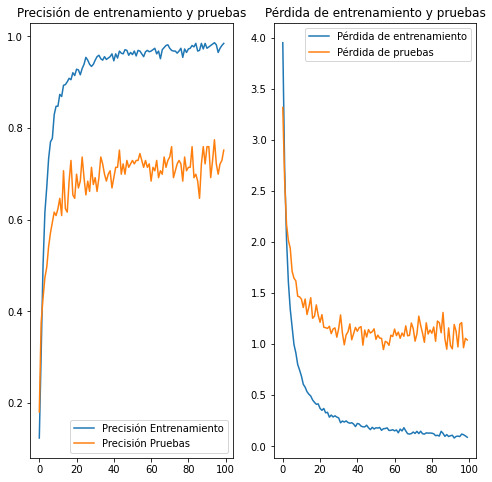

In [12]:
#Graficas de precisión
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [17]:
#Guardo el modelo para poder utilizarlo enotros codigos
model.save('banderitas.h5')

In [20]:
#IMPORTANTE
#Descarga el modelo desde el Github deberia aparecer en archivs tambien
!wget https://github.com/frangoler/flags-clasificator/raw/main/banderitas.h5

--2022-08-23 14:09:58--  https://github.com/frangoler/flags-clasificator/raw/main/banderitas.h5
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/frangoler/flags-clasificator/main/banderitas.h5 [following]
--2022-08-23 14:09:58--  https://raw.githubusercontent.com/frangoler/flags-clasificator/main/banderitas.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10055856 (9.6M) [application/octet-stream]
Saving to: ‘banderitas.h5’

banderitas.h5       100%[===================>]   9.59M  --.-KB/s    in 0.03s   

2022-08-23 14:09:58 (352 MB/s) - ‘banderitas.h5’ saved [10055856/10055856]



In [27]:
path='/content/banderitas.h5'
model_reloaded = tf.keras.models.load_model(
       (path),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [28]:
#Creo una funcion para la ejecucion prolija de el .predict
def resultados(url):
  #Ingreso una url de la web(si o si .jpg o .png, o algun archivo utilizado por keras mayor a 300x300 px)
  #Retorno una lista ordenada de mayor a menor con tuplas que contienen un float siendo este el valor de procentaje de probabilidad 
  #y en el otro valor un str que contiene el nombre correspondiente del pais
  respuesta = requests.get(url)
  img = Image.open(BytesIO(respuesta.content))
  img = np.array(img).astype(float)/255
  img = cv2.resize(img, (image_size,image_size))
  prediccion = model_reloaded.predict(img.reshape(-1, image_size, image_size, 3))
  lFinal=[]
  for i in range(len(prediccion[0])):
    t=(float(prediccion[0][i]),labels[i])
    lFinal.append(t)
  lFinal.sort(reverse=True)
  return lFinal 

In [29]:
url='https://image.winudf.com/v2/image/Y29tLkNoaWVmV2FsbHBhcGVycy5TcGEzNl9zY3JlZW5fMF9yZmlldzgxdg/screen-0.jpg?fakeurl=1&type=.webp' 
print(resultados(url))

[(0.7067584991455078, 'Spain'), (0.24487708508968353, 'Bolivia'), (0.01657230034470558, 'Romania'), (0.011363529600203037, 'Costa rica'), (0.00557827390730381, 'Peru'), (0.004651498980820179, 'Portugal'), (0.002479496179148555, 'Andorra'), (0.0017091530608013272, 'Barbados'), (0.0015568992821499705, 'Mexico'), (0.0012560382019728422, 'Luxembourg'), (0.0007567005814053118, 'Brasil'), (0.0006235881592147052, 'Venezuela'), (0.00038044838584028184, 'Germany'), (0.00036120793083682656, 'El Salvador'), (0.00022532801085617393, 'Malta'), (0.00022421249013859779, 'Belgium'), (0.00013893407594878227, 'Colombia'), (8.571847138227895e-05, 'Croatia'), (7.136799104046077e-05, 'Lithuania'), (6.669373397016898e-05, 'Argentina'), (5.7421748351771384e-05, 'Hungary'), (5.208636503084563e-05, 'Slovakia'), (3.957170702051371e-05, 'Austria'), (2.0605068129952997e-05, 'Ukraine'), (1.6562669770792127e-05, 'Czech Republic'), (1.5651248759240843e-05, 'Ireland'), (1.5567871741950512e-05, 'Paraguay'), (8.0851505